# **Transfer Learning Model**

## **Model Preprocessing**

### **Importing the dataset from google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Dataset Details**

In [ ]:
ls "/content/drive/My Drive/Malaria Detection /transfer learning/"

Negative/  negative1/  positive1/  Postive/


In [ ]:
import os
import glob

base_dir = os.path.join('/content/drive/My Drive/Malaria Detection /transfer learning/')
infected_dir = os.path.join(base_dir,'Postive')
healthy_dir = os.path.join(base_dir,'Negative')

infected_files = glob.glob(infected_dir+'/*.JPG')
healthy_files = glob.glob(healthy_dir+'/*.JPG')
print ('number of infected cells is ',len(infected_files),' number of healthy cells is ',len(healthy_files))


number of infected cells is  39  number of healthy cells is  40


In [ ]:
import numpy as np
import pandas as pd

np.random.seed(40)

files_df = pd.DataFrame({
    'filename': infected_files + healthy_files,
    'label': ['malaria'] * len(infected_files) + ['healthy'] * len(healthy_files)
}).sample(frac=1, random_state=40).reset_index(drop=True)

files_df.head()

,filename,label
0,/content/drive/My Drive/Malaria Detection /tra...,malaria
1,/content/drive/My Drive/Malaria Detection /tra...,healthy
2,/content/drive/My Drive/Malaria Detection /tra...,malaria
3,/content/drive/My Drive/Malaria Detection /tra...,healthy
4,/content/drive/My Drive/Malaria Detection /tra...,malaria


### **Create Train and Validation sets**

In [ ]:
from sklearn.model_selection import train_test_split
from collections import Counter

train_files, test_files, train_labels, test_labels = train_test_split(files_df['filename'].values,
                                                                      files_df['label'].values, 
                                                                      test_size=0.37)
#train_files, val_files, train_labels, val_labels = train_test_split(train_files, train_labels, test_size=0.16)  val_files.shape, '\nVal:', Counter(val_labels),

print(train_files.shape,  test_files.shape)
print('Train:', Counter(train_labels),  '\nTest:', Counter(test_labels))

(49,) (30,)
Train: Counter({'malaria': 27, 'healthy': 22}) 
Test: Counter({'healthy': 18, 'malaria': 12})


### **Load and Resize Training and Validation Images**

In [ ]:
import cv2
from concurrent import futures
import threading

IMG_DIMS = (125, 125)
def get_img_data_parallel(idx, img, total_imgs):
    if idx % 50 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    img = cv2.imread(img)
    img = cv2.resize(img, dsize=IMG_DIMS, 
                     interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

ex = futures.ThreadPoolExecutor(max_workers=None)
train_data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
#val_data_inp = [(idx, img, len(val_files)) for idx, img in enumerate(val_files)]
test_data_inp = [(idx, img, len(test_files)) for idx, img in enumerate(test_files)]

print('Loading Train Images:')
train_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in train_data_inp],
                        [record[1] for record in train_data_inp],
                        [record[2] for record in train_data_inp])
train_data = np.array(list(train_data_map))
'''
print('\nLoading Validation Images:')
val_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in val_data_inp],
                        [record[1] for record in val_data_inp],
                        [record[2] for record in val_data_inp])
val_data = np.array(list(val_data_map))
'''
print('\nLoading Test Images:')
test_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in test_data_inp],
                        [record[1] for record in test_data_inp],
                        [record[2] for record in test_data_inp])
test_data = np.array(list(test_data_map))

train_data.shape, '''val_data.shape''', test_data.shape  

Loading Train Images:
ThreadPoolExecutor-1_0: working on img num: 0
ThreadPoolExecutor-1_6: working on img num: 48

Loading Test Images:
ThreadPoolExecutor-1_3: working on img num: 0
ThreadPoolExecutor-1_1: working on img num: 29


((49, 125, 125, 3), 'val_data.shape', (30, 125, 125, 3))

### **Displaying the sets images and lables of each**

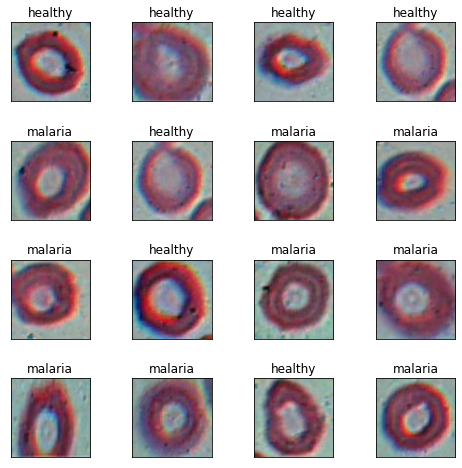

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1 , figsize = (8 , 8))
n = 0 
for i in range(16):
    n += 1 
    r = np.random.randint(0 , train_data.shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(train_data[r[0]]/255.)
    plt.title('{}'.format(train_labels[r[0]]))
    plt.xticks([]) , plt.yticks([])

In [ ]:
import tensorflow as tf
tf.random.set_seed(42)
tf.__version__

'2.6.0'

### **Images scaling and setup model configurations**

In [ ]:
BATCH_SIZE = 1
NUM_CLASSES = 2
INPUT_SHAPE = (125, 125, 3)

train_imgs_scaled = train_data / 255.
#val_imgs_scaled = val_data / 255.
test_imgs_data = test_data/255
# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
test_labels_enc = le.transform(test_labels)

print(train_labels[:6], train_labels_enc[:6])

['healthy' 'malaria' 'malaria' 'malaria' 'healthy' 'healthy'] [0 1 1 1 0 0]


### **Image Augmentaion**

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                zoom_range=0.05, 
                                                                rotation_range=25,
                                                                width_shift_range=0.05, 
                                                                height_shift_range=0.05, 
                                                                shear_range=0.05, horizontal_flip=True, 
                                                                fill_mode='nearest')

#val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


In [ ]:
train_generator = train_datagen.flow(train_data, train_labels_enc, batch_size=BATCH_SIZE, shuffle=True)
#val_generator = val_datagen.flow(val_data, val_labels_enc, batch_size=BATCH_SIZE, shuffle=False)

Labels: ['healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy']


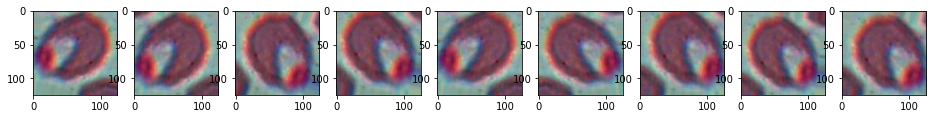

In [ ]:
img_id = 0
sample_generator = train_datagen.flow(train_data[img_id:img_id+1], train_labels[img_id:img_id+1],
                                      batch_size=1)
sample = [next(sample_generator) for i in range(0,9)]
fig, ax = plt.subplots(1,9, figsize=(16, 6))
print('Labels:', [item[1][0] for item in sample])
l = [ax[i].imshow(sample[i][0][0]) for i in range(0,9)]

## **Transfer Learning**

### **Build Model Architecture**

In [ ]:
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.models import Sequential 
from tensorflow.keras import layers, models, optimizers

In [ ]:
import tensorflow as tf 
cnn_model = tf.keras.models.load_model('/content/drive/My Drive/Malaria Detection /basic_cnn2_6.h5')

In [ ]:
weights_path = '/content/drive/My Drive/Malaria Detection /test/basic_cnn2_6.h5'
num_classes = 2
testing_model = Sequential()
cnn_model.trainable = False
print(cnn_model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 125, 125, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 125, 125, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 128)       0     

In [ ]:
for i in range(13):
    cnn_model.layers[i].trainable = False

In [ ]:
x = cnn_model.output
tf.keras.layers.BatchNormalization(
    axis=-1,
    momentum=0.99,
    epsilon=0.001,
    center=True,
    scale=True,
    beta_initializer="zeros",
    gamma_initializer="ones",
    moving_mean_initializer="zeros",
    moving_variance_initializer="ones",
    beta_regularizer=None,
    gamma_regularizer=None,
    beta_constraint=None,
    gamma_constraint=None)
hidden1 = tf.keras.layers.Dense(10, activation='relu')(x)
drop1 = tf.keras.layers.Dropout(rate=0.3)(x)
hidden2 = tf.keras.layers.Dense(10, activation='relu')(drop1)
#drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)
hidden3 = tf.keras.layers.Dense(10, activation='relu')(x)

outis = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

In [ ]:
transfer_model2 = tf.keras.Model(inputs=cnn_model.input, outputs= outis)

transfer_model2.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
                loss='binary_crossentropy',
                metrics=['accuracy'])
transfer_model2.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 125, 125, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 125, 125, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 128)       0   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
print("Total Layers:", len(transfer_model.layers))
print("Total trainable layers:", sum([1 for l in transfer_model.layers if l.trainable]))

Total Layers: 17
Total trainable layers: 4


### **Train Model**

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.000001)

train_steps_per_epoch = train_generator.n // train_generator.batch_size
val_steps_per_epoch = val_generator.n // val_generator.batch_size
history = transfer_model.fit_generator(train_generator, steps_per_epoch=train_steps_per_epoch, epochs=100,
                              validation_data=val_generator, validation_steps=val_steps_per_epoch, 
                              verbose=1)

In [ ]:
train_steps_per_epoch = train_generator.n // train_generator.batch_size
#val_steps_per_epoch = val_generator.n // val_generator.batch_size
history = transfer_model.fit_generator(train_generator,
                                       steps_per_epoch=train_steps_per_epoch, 
                                       epochs=50,
                             # validation_data=val_generator, 
                             # validation_steps=val_steps_per_epoch, 
                              verbose=1)

Epoch 1/50
 4/49 [=>............................] - ETA: 0s - loss: 0.7402 - accuracy: 0.0000e+00

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


49/49 [==============================] - 1s 21ms/step - loss: 0.6969 - accuracy: 0.4898
Epoch 2/50
49/49 [==============================] - 1s 21ms/step - loss: 0.6937 - accuracy: 0.5102
Epoch 3/50
49/49 [==============================] - 1s 21ms/step - loss: 0.6954 - accuracy: 0.4490
Epoch 4/50
49/49 [==============================] - 1s 20ms/step - loss: 0.6807 - accuracy: 0.5918
Epoch 5/50
49/49 [==============================] - 1s 21ms/step - loss: 0.6963 - accuracy: 0.5102
Epoch 6/50
49/49 [==============================] - 1s 21ms/step - loss: 0.6950 - accuracy: 0.5714
Epoch 7/50
49/49 [==============================] - 1s 20ms/step - loss: 0.7015 - accuracy: 0.4694
Epoch 8/50
49/49 [==============================] - 1s 20ms/step - loss: 0.7008 - accuracy: 0.4898
Epoch 9/50
49/49 [==============================] - 1s 20ms/step - loss: 0.6892 - accuracy: 0.5510
Epoch 10/50
49/49 [==============================] - 1s 21ms/step - loss: 0.7062 - accuracy: 0.3673
Epoch 11/50
49/49 [=

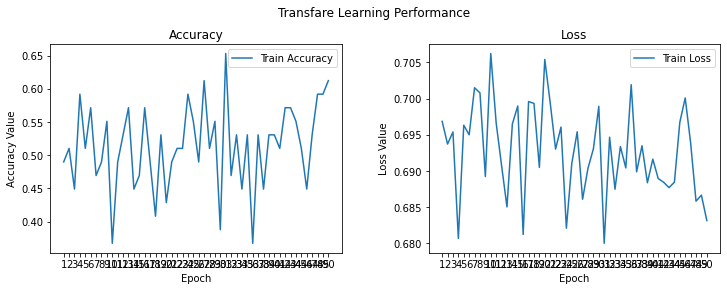

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Transfare Learning Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
#ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")
ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
#ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

### **Trainning Accuracy and Validating Accuracy**

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Transfare Learning Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
#ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")


ax2.plot(epoch_list, history.history['loss'], label='Loss')
ax2.set_xticks(np.arange(1, max_epoch, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

### **Save the Model**

In [ ]:
transfer_model.save('/content/drive/My Drive/Malaria Detection /transfer_learning2.h5')

In [ ]:
transfer_model = tf.keras.models.load_model('/content/drive/My Drive/Malaria Detection /transfer_learning2.h5')

In [ ]:
transfer_model.build(INPUT_SHAPE) # `input_shape` is the shape of the input data
                         # e.g. input_shape = (None, 32, 32, 3)
transfer_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 125, 125, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 125, 125, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 128)       0   

## **Model Evaluation Metrics**

In [ ]:
test_imgs_scaled = test_data / 255.
test_imgs_scaled.shape, test_labels.shape

((30, 125, 125, 3), (30,))

In [ ]:
tl = tf.keras.models.load_model('/content/drive/My Drive/Malaria Detection /transfer_learning2.h5')

### **ROC**

# Threshold = 0.05

In [ ]:
tl_preds = tl.predict(test_imgs_data, batch_size=1)
tl_pred_labels = le.inverse_transform([1 if pred > .6 else 0 
                                                  for pred in tl_preds.ravel()])
tl_preds.ravel()



array([0.52154744, 0.51476157, 0.51476187, 0.51476157, 0.51476157,
       0.51476157, 0.51476157, 0.52278435, 0.51476157, 0.51476157,
       0.51476157, 0.51476157, 0.51476157, 0.51476157, 0.51476157,
       0.51476157, 0.5147834 , 0.51476157, 0.51476157, 0.51476157,
       0.5147621 , 0.51476157, 0.52053195, 0.51476157, 0.51479006,
       0.51476157, 0.51476157, 0.51476157, 0.51476157, 0.51476157],
      dtype=float32)

In [ ]:
test_labels

array(['malaria', 'healthy', 'malaria', 'healthy', 'malaria', 'malaria',
       'malaria', 'healthy', 'malaria', 'healthy', 'healthy', 'healthy',
       'malaria', 'malaria', 'malaria', 'healthy', 'healthy', 'healthy',
       'healthy', 'healthy', 'malaria', 'healthy', 'healthy', 'healthy',
       'malaria', 'malaria', 'healthy', 'healthy', 'healthy', 'healthy'],
      dtype=object)

In [ ]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
cf_matrix = confusion_matrix(test_labels,tl_pred_labels)
print(cf_matrix)

[[18  0]
 [12  0]]


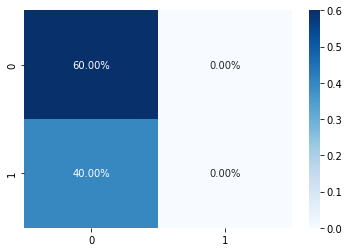

In [ ]:
import seaborn as sns
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [ ]:
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(test_labels,tl_pred_labels)
accuracy

0.6

###**Error Rate**

In [ ]:
Error_rate=1-(accuracy)
print(Error_rate)

0.5


### **Precision**

In [ ]:
from sklearn.metrics import precision_score
positive = precision_score(test_labels,tl_pred_labels,pos_label='healthy')
print(positive)

In [ ]:
negative = precision_score(test_labels,tl_pred_labels,pos_label='malaria')
print(negative)

0.5


###**Recall**

In [ ]:
from sklearn.metrics import recall_score
positive = recall_score(test_labels,tl_pred_labels,pos_label='healthy')
print(positive)

0.0


In [ ]:
negative = recall_score(test_labels,tl_pred_labels,pos_label='malaria')
print(negative)

1.0


### **F1 Score**

In [ ]:
from sklearn.metrics import f1_score
postive = f1_score(test_labels,tl_pred_labels,pos_label='healthy')
print(postive)

0.0


In [ ]:
negative = f1_score(test_labels,tl_pred_labels,pos_label='malaria')
print(negative)

0.6666666666666666


### **Specificity**

In [ ]:
specificity = cf_matrix[1,1]/(cf_matrix[1,0]+cf_matrix[1,1])
print (specificity)

1.0
